In [2]:
import sys, os, pygmt, importlib, re
mod_path = '/home/581/da1339/AFIM/src/AFIM/src'
sys.path.insert(0, mod_path)
from sea_ice_toolbox      import SeaIceToolbox
from datetime             import timedelta, date, datetime
from pathlib              import Path
from dask.distributed     import Client, LocalCluster
import numpy              as np
import pandas             as pd
import xarray             as xr
import xesmf              as xe
from collections          import defaultdict
import matplotlib.pyplot  as plt
from scipy.interpolate    import interp1d
from matplotlib.offsetbox import AnchoredOffsetbox, VPacker, TextArea
import matplotlib.dates   as mdates
import matplotlib.animation as animation
from pyproj               import CRS, Transformer

In [ ]:
import sea_ice_toolbox
importlib.reload(sea_ice_toolbox)
from sea_ice_toolbox  import SeaIceToolbox

In [46]:
sim_name   = "elps-min"
dt0_str    = "1999-01-01"
dtN_str    = "1999-12-31"
dt_rng_str = f"{dt0_str[:4]}-{dtN_str[:4]}"
ice_type   = "FI_BT"
SIA_dict   = {}
FIA_dict   = {}
SI_tools   = SeaIceToolbox(sim_name             = sim_name,
                           dt0_str              = dt0_str,
                           dtN_str              = dtN_str,
                           ice_speed_threshold  = 5e-4,
                           ice_speed_type       = "ispd_BT",
                           ice_type             = "FI_BT",
                           overwrite_zarr       = True,
                           save_new_figs        = True,
                           show_figs            = True,
                           overwrite_saved_figs = True)

2025-06-19 11:39:31,098 - INFO - log file initialised: /g/data/gv90/da1339/logs/SeaIceProcessor_FI_elps-min.log
INFO:elps-min:log file initialised: /g/data/gv90/da1339/logs/SeaIceProcessor_FI_elps-min.log
2025-06-19 11:39:33,471 - INFO - Initialized new Dask client.
INFO:elps-min:Initialized new Dask client.
2025-06-19 11:39:33,476 - INFO - Dask distributed client can be accessed at url /proxy/8787/status
INFO:elps-min:Dask distributed client can be accessed at url /proxy/8787/status
2025-06-19 11:39:33,478 - INFO - hemisphere initialised: SH
INFO:elps-min:hemisphere initialised: SH


In [ ]:
#SI_tools.compute_grounded_iceberg_area()
sims        = ["elps-min", "gi-nil", "AOM2-ERA5", "FI-heavy", "Roth-cf-def", "re-evp-off", "ndte-max", "ndte-min", "ktens-ext", "elps-ext", "elps-max"]
regions     = ["north", "south"]
var_names   = ["aice", "hi", "dvidtd", "dvidtt"]
video_paths = {sim: {region: {} for region in regions} for sim in sims}
dt0_str     = "1999-01-01"
dtN_str     = "1999-12-31"
# # STEP 1: Generate PNG frames
# for sim_name in sims:
#     for var_name in var_names:
SI_tools = SeaIceToolbox(sim_name             = sim_name,
                         dt0_str              = dt0_str,
                         dtN_str              = dtN_str,
                         P_log                = f"/g/data/gv90/da1339/logs/SeaIceToolBox_{sims[0]}_{var_names[0]}_plotting.log",
                         save_new_figs        = True,
                         show_figs            = True,
                         overwrite_saved_figs = True)
CICE_all   = SI_tools.load_iceh_zarr()
CICE_slice = CICE_all.sel(time=slice(dt0_str,dtN_str))
#        for i,dt in enumerate(CICE_slice['time'].values):

In [ ]:
#FI_sim = xr.open_mfdataset("/g/data/gv90/da1339/afim_output/elps-min/FI-sim-TS_elps-min_*.nc")#zarr/ispd_thresh_5.0e-4/metrics/FI_BT_bool_mets.zarr", engine="zarr")
FI_sim = xr.open_zarr("/g/data/gv90/da1339/afim_output/elps-min/zarr/ispd_thresh_5.0e-4/cice_daily_1996-09.zarr", group="FI_BT")

In [51]:
da         = FI_sim['FI_mask'].isel(nj=slice(25,75), ni=slice(300,400))
fig, ax    = plt.subplots(figsize=(10,10))
vmin, vmax = 0, 1 
img        = da.isel(time=0).plot.imshow(ax=ax, vmin=vmin, vmax=vmax, cmap='viridis', add_colorbar=False)
title      = ax.set_title("")
def update(i):
    dt     = pd.Timestamp(da.time.isel(time=i).values)
    dt_str = f"{dt.year}-{dt.month:02d}-{dt.day:02d}"
    img.set_data(da.isel(time=i))
    title.set_text(f"{dt_str}")
    return img,
ani = animation.FuncAnimation( fig, update, frames=len(da.time), interval=200, blit=False )
plt.close()
HTML(ani.to_jshtml())
ani.save("/g/data/gv90/da1339/GRAPHICAL/AFIM/animations/elps-min/FI_mask_ispd-BT_raw_animation.mp4", writer="ffmpeg", fps=5, dpi=150)

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1500x1500 -pix_fmt rgba -framerate 5 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /g/data/gv90/da1339/GRAPHICAL/AFIM/animations/elps-min/FI_mask_ispd-BT_raw_animation.mp4


In [50]:
da_bool = SI_tools.boolean_fast_ice(da)
da_bool

2025-06-19 11:47:25,963 - INFO - 🔁 Rolling boolean presence: window = 7, min_count = 6
INFO:elps-min:🔁 Rolling boolean presence: window = 7, min_count = 6


<xarray.DataArray 'FI_mask' (time: 30, nj: 50, ni: 100)> Size: 150kB
dask.array<ge, shape=(30, 50, 100), dtype=bool, chunksize=(29, 17, 34), chunktype=numpy.ndarray>
Coordinates:
    TLAT     (nj, ni) float32 20kB dask.array<chunksize=(50, 100), meta=np.ndarray>
    TLON     (nj, ni) float32 20kB dask.array<chunksize=(50, 100), meta=np.ndarray>
    ULAT     (nj, ni) float32 20kB dask.array<chunksize=(50, 100), meta=np.ndarray>
    ULON     (nj, ni) float32 20kB dask.array<chunksize=(50, 100), meta=np.ndarray>
    lat      (nj, ni) float64 40kB dask.array<chunksize=(50, 100), meta=np.ndarray>
    lon      (nj, ni) float64 40kB dask.array<chunksize=(50, 100), meta=np.ndarray>
  * ni       (ni) int64 800B 300 301 302 303 304 305 ... 394 395 396 397 398 399
  * nj       (nj) int64 400B 25 26 27 28 29 30 31 32 ... 67 68 69 70 71 72 73 74
  * time     (time) datetime64[ns] 240B 1996-09-01 1996-09-02 ... 1996-09-30

In [52]:
fig, ax    = plt.subplots(figsize=(10,10))
vmin, vmax = 0, 1 
img        = da_bool.isel(time=0).plot.imshow(ax=ax, vmin=vmin, vmax=vmax, cmap='viridis', add_colorbar=False)
title      = ax.set_title("")
def update(i):
    dt     = pd.Timestamp(da_bool.time.isel(time=i).values)
    dt_str = f"{dt.year}-{dt.month:02d}-{dt.day:02d}"
    img.set_data(da_bool.isel(time=i))
    title.set_text(f"{dt_str}")
    return img,
ani = animation.FuncAnimation( fig, update, frames=len(da_bool.time), interval=200, blit=False )
plt.close()
HTML(ani.to_jshtml())
ani.save("/g/data/gv90/da1339/GRAPHICAL/AFIM/animations/elps-min/FI_mask_ispd-BT_bool_animation.mp4", writer="ffmpeg", fps=5, dpi=150)

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1500x1500 -pix_fmt rgba -framerate 5 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /g/data/gv90/da1339/GRAPHICAL/AFIM/animations/elps-min/FI_mask_ispd-BT_bool_animation.mp4


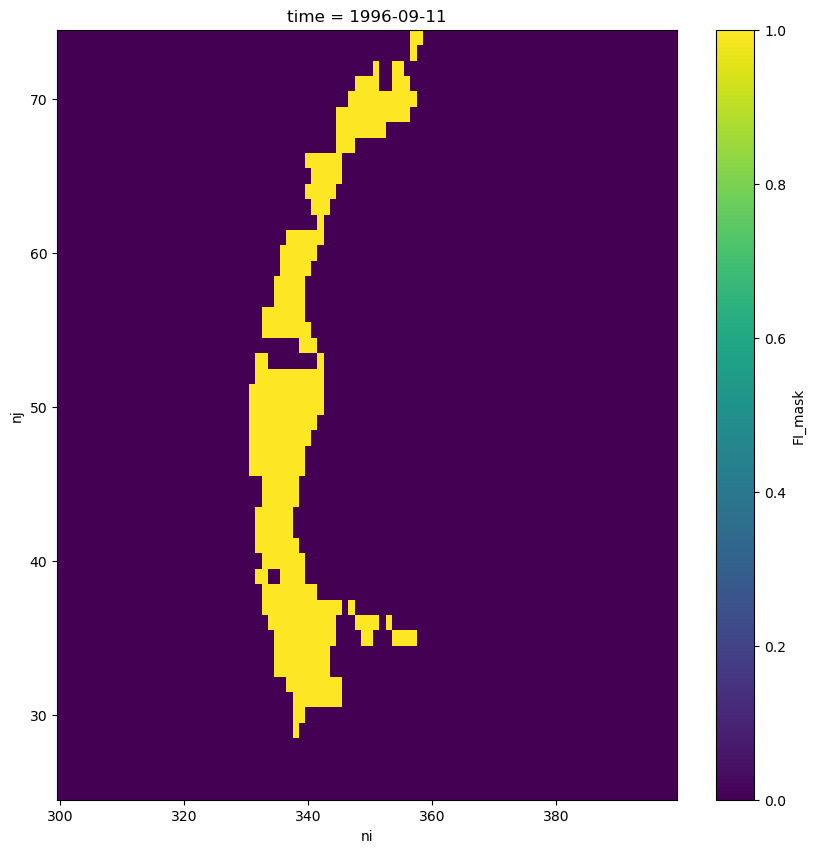

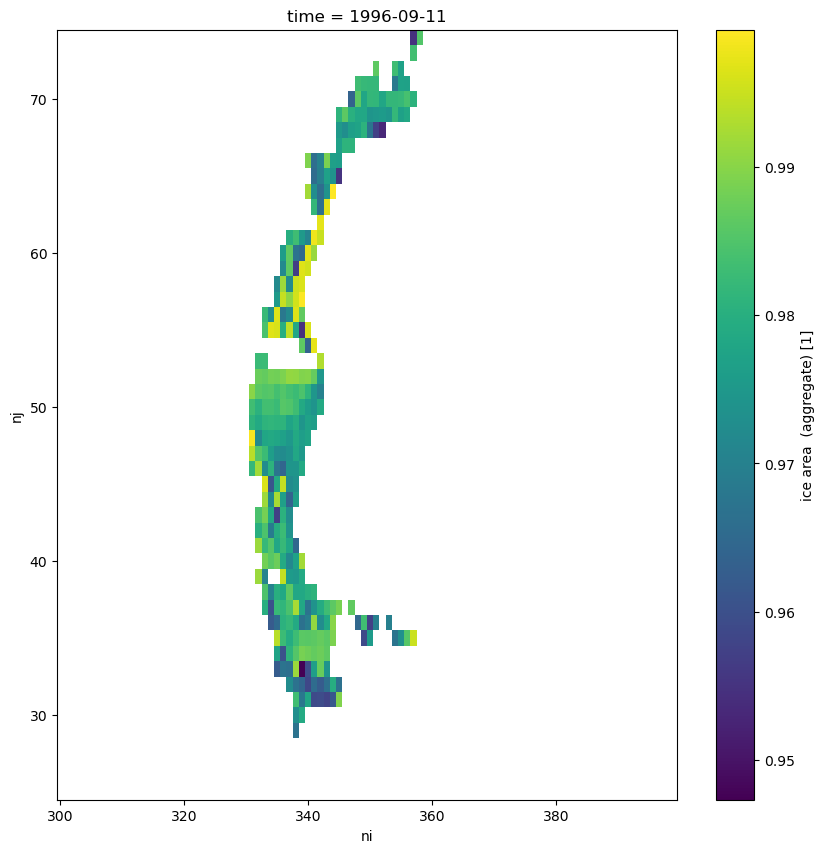

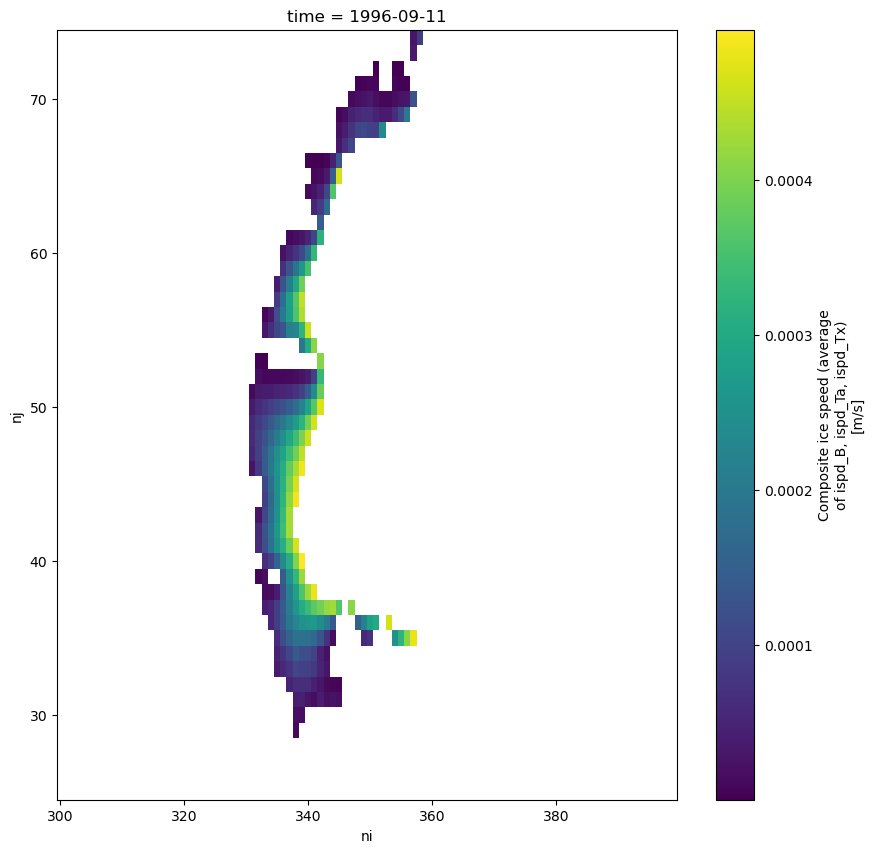

In [ ]:
FI_sim['FI_mask'].isel(time=10,nj=slice(25,75),ni=slice(300,400)).plot(figsize=(10,10))

FI_sim['aice'].isel(time=10,nj=slice(25,75),ni=slice(300,400)).plot(figsize=(10,10))
FI_sim['ispd_BT'].isel(time=10,nj=slice(25,75),ni=slice(300,400)).plot(figsize=(10,10))

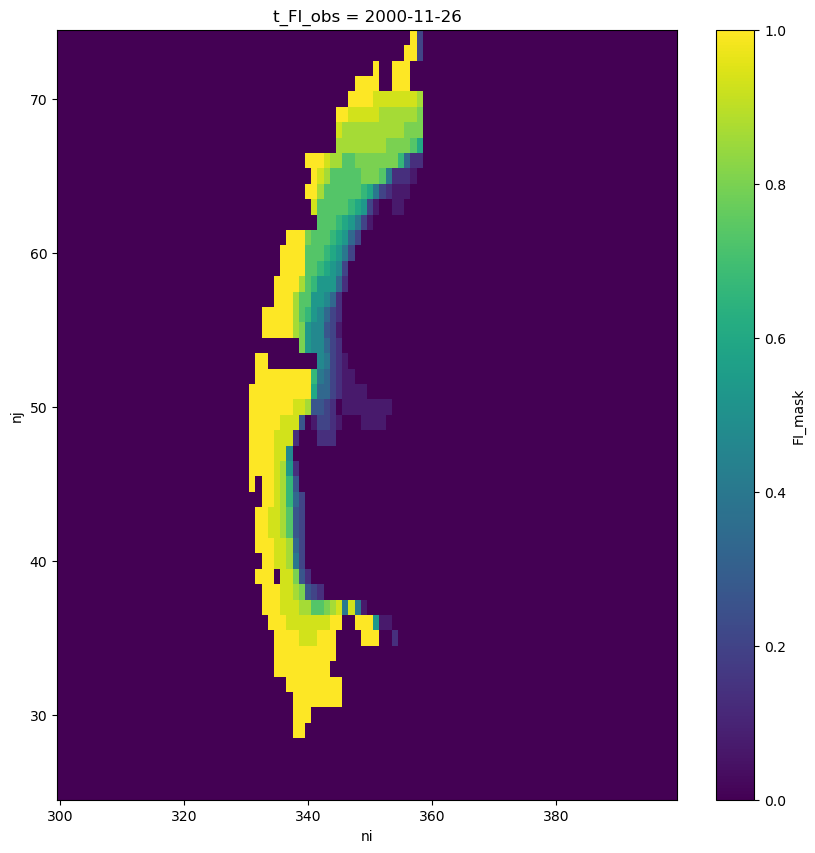

In [28]:
FI_sim['FI_mask'].isel(t_FI_obs=18+4,nj=slice(25,75),ni=slice(300,400)).plot(figsize=(10,10))

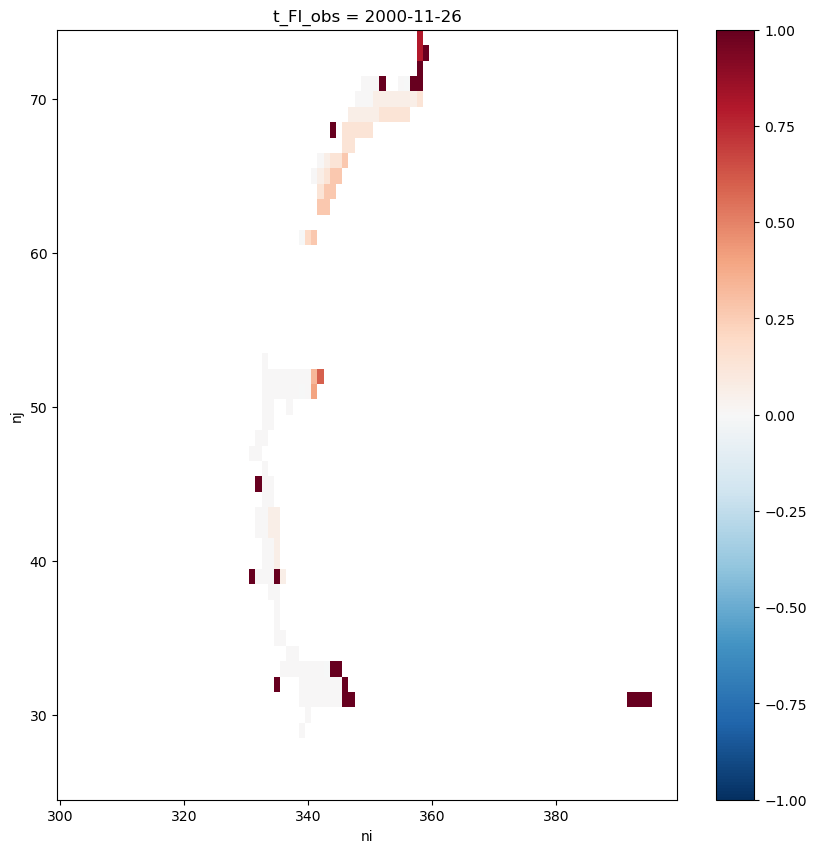

In [31]:
da_FI_sim = FI_sim['FI_mask'].isel(t_FI_obs=18+4,nj=slice(25,75),ni=slice(300,400))
da_FI_obs = FI_obs.FI.isel(t_FI_obs=18,nj=slice(25,75),ni=slice(300,400))
da_FI_diff = da_FI_obs - da_FI_sim
da_FI_diff.plot(figsize=(10,10))

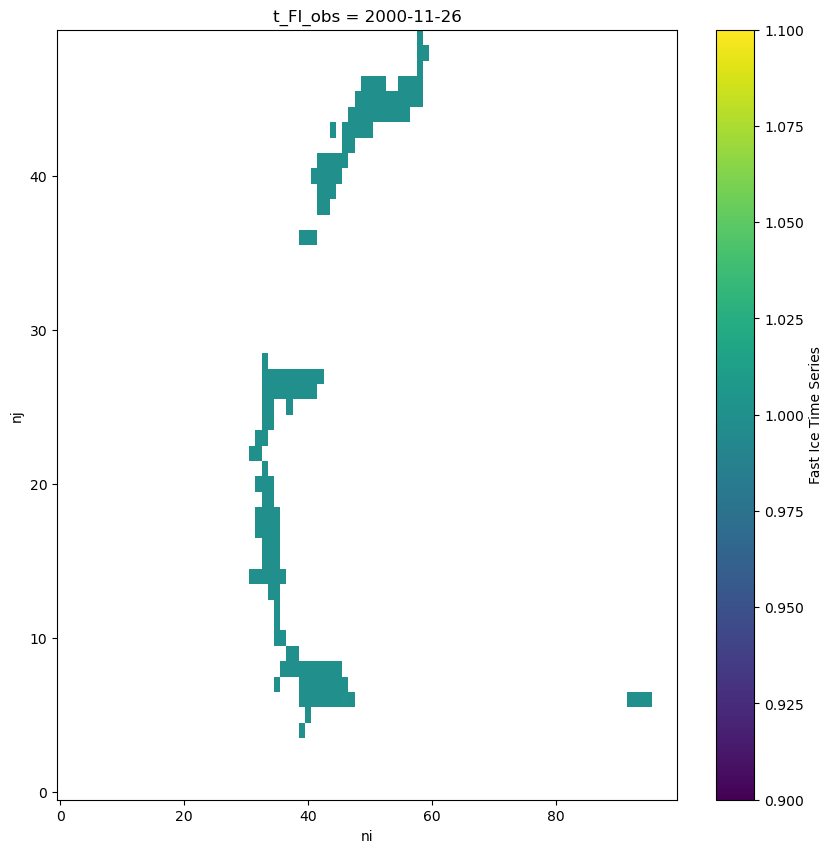

In [29]:

FI_obs = xr.open_dataset("/g/data/gv90/da1339/SeaIce/FI_obs/AF-FI-2020db_org-timestep_reG.zarr", engine="zarr")
FI_obs.FI.isel(t_FI_obs=18,nj=slice(25,75),ni=slice(300,400)).plot(figsize=(10,10))
#print(FI_sim['FIP'])
#print(FI_obs)
#FI_obs_FIP = FI_obs.FI.sum(dim="t_FI_obs") / len(FI_obs.t_FI_obs)
#print(FI_obs_FIP)
#FI_ttl_mean_diff = ds.FI_diff.sum(dim='t_FI_obs') / len(ds.t_FI_obs)
#FI_ttl_mean_diff

In [22]:
FIP_diff = FI_obs_FIP.isel(nj=slice(0,540)) - FI_sim['FIP']
FIP_diff

<xarray.DataArray (nj: 540, ni: 1440)> Size: 6MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    lat      (nj, ni) float64 6MB -81.08 -81.08 -81.08 ... 10.32 10.32 10.32
  * ni       (ni) int64 12kB 0 1 2 3 4 5 6 ... 1434 1435 1436 1437 1438 1439
  * nj       (nj) int64 4kB 0 1 2 3 4 5 6 7 ... 532 533 534 535 536 537 538 539
    TLAT     (nj, ni) float32 3MB ...
    TLON     (nj, ni) float32 3MB ...
    ULAT     (nj, ni) float32 3MB ...
    ULON     (nj, ni) float32 3MB ...

In [31]:
ds_slice = FI_sim.sel(time="2008-12-23")#,nj=SI_tools.hemisphere_dict['nj_slice'])
# plt_da   = ds_slice[var_names[0]]
# dt       = pd.Timestamp(plt_da.time.values)
# dt_str   = f"{dt.year}-{dt.month:02d}-{dt.day:02d}"
SI_tools.pygmt_map_plot_one_var(ds_slice, 'aice',
                                plot_regions  = 2,
                                time_stamp    = "2008-12-23",
                                tit_str       = "2008-12-23",
                                lon_coord_name = 'lon',
                                lat_coord_name = 'lat',
                                plot_GI        = True,
                                    cbar_label     = "fast ice concentration",
                                    cbar_units     = "1/100",
                                    var_sq_size    = 0.05,
                                show_fig      = True)

KeyError: "'time' is not a valid dimension or coordinate for Dataset with dimensions FrozenMappingWarningOnValuesAccess({'t_FI_obs': 456, 'nj': 540, 'ni': 1440})"

In [ ]:
af2020_df                = pd.read_csv(SI_tools.AF_FI_dict['P_AF2020_cli_csv'])
FIA_dict["AF2020db_cli"] = SI_tools.interpolate_obs_fia(af2020_df)
ice_types                = [ice_type, f"{ice_type}_roll", f"{ice_type}_bool"]

In [ ]:
for i_type in ice_types:
    P_METS = Path(SI_tools.D_metrics, f"{i_type}_mets.zarr")
    P_sum  = Path(SI_tools.D_metrics, f"{i_type}_summary.csv")
    if P_METS.exists() and not SI_tools.overwrite_zarr_group:
        print(f"{P_METS} exists and not overwriting--loading")
        METS             = xr.open_zarr(P_METS)
        FIA_dict[i_type] = METS['FIA']
    else:
        print(f"{P_METS} does NOT exists and/or overwriting--computing")
        roll        = i_type.endswith("_roll")
        DS, CICE_SO = SI_tools.load_processed_cice(ice_type    = ice_type,
                                                  zarr_CICE   = True,
                                                  rolling     = roll,
                                                  slice_hem   = True)
        if i_type==f"{ice_type}_bool":
            bool_mask          = SI_tools.boolean_fast_ice(DS['FI_mask'], dim="time", window=7, min_count=6)
            DS_bool            = CICE_SO.where(bool_mask)
            DS_bool["FI_mask"] = DS["FI_mask"]
            DS                 = DS_bool
        METS = SI_tools.compute_sea_ice_metrics(DS, sim_name, i_type, SI_tools.ispd_thresh_str, P_METS, P_sum, FIA_dict["AF2020db_cli"])
    FIA_dict[i_type] = METS['FIA']

In [ ]:
FIA_dict

In [ ]:
P_png = Path(SI_tools.D_graph, sim_name, f"FIA_FIP_{sim_name}_{dt_rng_str}.png")
SI_tools.plot_FIA_FIP_faceted(FIA_dict, METS['FIP'], P_png=P_png, plot_GI=True)

In [ ]:
#SI_tools.correct_timestamp_for_all_monthly_zarr_iceh(sim_names=)
for sim in ["Cstar-min","eap-FI","elps-max","elps-min","gi-max","gi-min","gi-nil-def",
            "ktens-ext","ktens-min","ndte-max","Pstar-max","re-evp-off","Roth-cf-max","ry93",
            "Cstar-max","eap-def","elps-ext","elps-mid","FI-heavy","gi-mid","gi-nil","ktens-max",
            "ktens-nil","ndte-min","Pstar-min","Roth-cf-def","Roth-cf-min","visc-meth"]:
    SI_tools = SeaIceToolbox(sim_name             = sim,
                             dt0_str              = dt0_str,
                             dtN_str              = "2023-12-31",
                             ice_speed_threshold  = 5e-4,
                             ice_speed_type       = "ispd_BT",
                             ice_type             = "FI_BT",
                             overwrite_zarr       = False,
                             save_new_figs        = True,
                             show_figs            = True,
                             overwrite_saved_figs = True)
    SI_tools.daily_iceh_to_monthly_zarr(overwrite=False, delete_original=True)

In [ ]:
var_name = "hi"

In [ ]:
DS, CICE            = SI_tools.load_processed_cice(ispd_thresh = 5e-4,
                                                   ice_type    = "FI_BT",
                                                   zarr_CICE   = True,
                                                   rolling     = False,
                                                   slice_hem   = False)

In [ ]:
CICE_ispds          = SI_tools.compute_ice_speed_types( CICE , ['ispd_BT'] )
CICE_reM            = SI_tools.reapply_landmask( CICE_ispds )
CICE_reM['ispd_BT'] = SI_tools.compute_composite_ice_speed( CICE_reM )

In [ ]:
CICE_reM

In [ ]:
ds_slice = CICE_reM.isel(time=2400, nj=SI_proc.hemisphere_dict['nj_slice'])
plt_da   = ds_slice[var_name]
SIA = SI_proc.compute_ice_area( ds_slice['aice'] , ds_slice['tarea'] , ice_area_scale=SI_proc.SIC_scale )
SIA.values

In [2]:
sim_name   = "elps-min"
dt0_str    = "1993-01-01"
dtN_str    = "1999-12-31"
dt_rng_str = f"{dt0_str[:4]}-{dtN_str[:4]}"
ice_type   = "FI_BT"
SIA_dict   = {}
FIA_dict   = {}
SI_tools   = SeaIceToolbox(sim_name             = sim_name,
                           dt0_str              = dt0_str,
                           dtN_str              = dtN_str,
                           ice_speed_threshold  = 5e-4,
                           ice_speed_type       = "ispd_BT",
                           ice_type             = "FI_BT",
                           overwrite_zarr       = True,
                           save_new_figs        = True,
                           show_figs            = True,
                           overwrite_saved_figs = True)
CICE_all            = SI_tools.load_iceh_zarr()
CICE_ispds          = SI_tools.compute_ice_speed_types( CICE_all, ['ispd_BT'] )
CICE_reM            = SI_tools.reapply_landmask( CICE_ispds )
CICE_reM['ispd_BT'] = SI_tools.compute_composite_ice_speed( CICE_reM )
for i in np.arange(2400,2500,1):
    ds_slice = CICE_reM.isel(time=i, nj=SI_tools.hemisphere_dict['nj_slice'])
    plt_da   = ds_slice['ispd_BT']
    dt       = pd.Timestamp( plt_da.time.values )
    dt_str   = f"{dt.year}-{dt.month:02d}-{dt.day:02d}"
    SI_tools.pygmt_map_plot_one_var(plt_da, 'ispd_BT',
                                    plot_regions  = 8,
                                    time_stamp    = dt_str,
                                    tit_str       = dt_str,
                                    plot_GI       = True,
                                    var_sq_size   = 0.2,
                                    series        = (0,.5),
                                    GI_fill_color = 'red', 
                                    GI_sq_size    = 0.075,
                                    extend_cbar   = True,
                                    show_fig      = False)

2025-06-13 14:53:28,555 - INFO - log file intialised: /g/data/gv90/da1339/logs/SeaIceProcessor_FI_elps-min.log
2025-06-13 14:53:28,558 - INFO - hemisphere initialised: SH
2025-06-13 14:53:28,568 - INFO - Loading monthly Zarr: /g/data/gv90/da1339/afim_output/elps-min/zarr/iceh_1993-01.zarr
2025-06-13 14:53:31,154 - INFO - Loading monthly Zarr: /g/data/gv90/da1339/afim_output/elps-min/zarr/iceh_1993-02.zarr
INFO:elps-min:Loading monthly Zarr: /g/data/gv90/da1339/afim_output/elps-min/zarr/iceh_1993-02.zarr
2025-06-13 14:53:31,184 - INFO - Loading monthly Zarr: /g/data/gv90/da1339/afim_output/elps-min/zarr/iceh_1993-03.zarr
INFO:elps-min:Loading monthly Zarr: /g/data/gv90/da1339/afim_output/elps-min/zarr/iceh_1993-03.zarr
2025-06-13 14:53:31,214 - INFO - Loading monthly Zarr: /g/data/gv90/da1339/afim_output/elps-min/zarr/iceh_1993-04.zarr
INFO:elps-min:Loading monthly Zarr: /g/data/gv90/da1339/afim_output/elps-min/zarr/iceh_1993-04.zarr
2025-06-13 14:53:31,242 - INFO - Loading monthly Zarr

In [ ]:
#sim_names       = SI_proc.config.get('sim_dict').keys()
#SI_proc.correct_timestamp_for_all_monthly_zarr_iceh( sim_names=sim_names, dry_run=False )
SI_proc.daily_iceh_to_monthly_zarr(overwrite=overwrite_zarr, delete_original=delete_original)
NSIDC             = SI_proc.compute_NSIDC_metrics()
SIA_dict['NSIDC'] = NSIDC['SIA']
# if daily:
#     DS_daily = SI_proc.process_daily_cice(ispd_type            = ispd_types,
#                                           overwrite_zarr_group = overwrite_zarr)
# if rolling:
#     DS_roll = SI_proc.process_rolling_cice(mean_period          = roll_period,
#                                            ispd_type            = ispd_types,
#                                            overwrite_zarr_group = overwrite_zarr)
DS, CICE_SO       = SI_proc.load_processed_cice(ispd_thresh = ispd_thresh,
                                          ice_type    = ice_types[0],
                                          zarr_CICE   = True,
                                          rolling     = True if ice_types[0]==f"{ice_types[0]}_roll" else False,
                                          slice_hem   = True)
SIA_dict[sim_name] = SI_proc.compute_ice_area(CICE_SO['aice'], CICE_SO['tarea'], ice_area_scale=SI_proc.SIC_scale)
SI_plot.plot_monthly_ice_area_by_year(SIA_dict,
                                      ice_type = "SI",
                                      tit_str  = tit_str,
                                      P_png    = P_png,
                                      ylim     = (1,20))

In [ ]:
SI_proc.sim_config

In [ ]:
#FIA_dict[sim_name]       = SI_proc.compute_ice_area(DS['aice'], DS['tarea']).compute()
#tit_str = f"Fast Ice Area Southern Ocean, {dt_rng_str}, AF2020db Climatology and Station Names: {sim_name}"
ktens    = SI_proc.sim_config['Ktens']
elps     = SI_proc.sim_config['e_yieldcurve']
ndte     = SI_proc.sim_config['ndte']
Cf       = SI_proc.sim_config['Cf']
GI_thin  = 1 - SI_proc.sim_config['GI_thin_fact']
#Pstar = float(SI_proc.sim_config['Pstar'].replace("D", "E"))
tit_str  = f"simulation name: {sim_name}\ntested CICE namelist parameter: Rothrock Strength Formulation; Cf={Cf}, ktens={ktens}, e={elps}, GI-concentration={GI_thin:0.2f};"
P_png    = Path(SI_plot.D_graph, "timeseries", f"FIA_AF2020db_and_{sim_name}_{dt_rng_str}.png")
SI_plot.plot_monthly_ice_area_by_year(FIA_dict,
                                      ice_type = "FI",
                                      tit_str  = tit_str,
                                      P_png    = P_png)